# learning-AI101 : raisin classification (DL)
### 건포도 데이터를 Dense layer struction을 통한 DNN 방식 및 CNN을 적용하여 classification 

<br>

- **임규연 (lky473736)**
- 2024.07.30. ~ 2024.08.01.에 DL 작성
- **dataset** : https://archive.ics.uci.edu/dataset/850/raisin
- **data abstract** : Images of Kecimen and Besni raisin varieties grown in Turkey were obtained with CVS. A total of 900 raisin grains were used, including 450 pieces from both varieties. These images were subjected to various stages of pre-processing and 7 morphological features were extracted. These features have been classified using three different artificial intelligence techniques.

------

- **CAUTION** : 데이터 EDA는 raisin classification (ML)에서 진행하여, 본 문서에서는 진행하지 않습니다.

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras

In [91]:
# 데이터 불러오기

df = pd.read_excel('./data/Raisin_Dataset/Raisin_Dataset.xlsx')
df.info()
print (df.columns)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             900 non-null    int64  
 1   MajorAxisLength  900 non-null    float64
 2   MinorAxisLength  900 non-null    float64
 3   Eccentricity     900 non-null    float64
 4   ConvexArea       900 non-null    int64  
 5   Extent           900 non-null    float64
 6   Perimeter        900 non-null    float64
 7   Class            900 non-null    object 
dtypes: float64(5), int64(2), object(1)
memory usage: 56.4+ KB
Index(['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
       'ConvexArea', 'Extent', 'Perimeter', 'Class'],
      dtype='object')


,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,Kecimen
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,Kecimen


-----

## <span id='dl'><mark>DL</mark></span>
    
deep learning으로 raisin을 classification한다. 목차는 아래와 같다.

- **1. SGDClassifier를 통한 ML에서의 확률적 경사 하강법 적용**
- **2. ANN (fully connected)**
- **3. DNN**
- **4. CNN**

-------

### 1. SGDClassifier를 통한 ML에서의 확률적 경사 하강법 적용
deep learning을 하기 전, deep learning의 weight 및 bias 조정법인 **SGD (Stochastic Gradient Descent)** 를 scikit-learn으로 구현 후 classification score를 확인해본다. parameter는 random search를 통하여 최적화할 것이며, 자세한 조정범위는 아래에 서술한다.
- loss function : log_loss (logistic regression (sigmoid))
- max_iter : 10~30 (randint)

In [92]:
# data split 및 normalization

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

raisin_input = df[df.columns[:-1]]
raisin_target = df[df.columns[-1]]

X_train, X_test, y_train, y_test = train_test_split(raisin_input, raisin_target, 
                                                   stratify=raisin_target, test_size=0.2)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [93]:
# random search를 통한 hyperparameter tuning

from sklearn.linear_model import SGDClassifier
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

param = {
    'max_iter' : randint(10, 30)
}

sc = SGDClassifier(loss='log_loss')
rs = RandomizedSearchCV(sc, param, n_iter=20, n_jobs=-1)
rs.fit (X_train_scaled, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reache

RandomizedSearchCV(estimator=SGDClassifier(loss='log_loss'), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1476c9f50>})

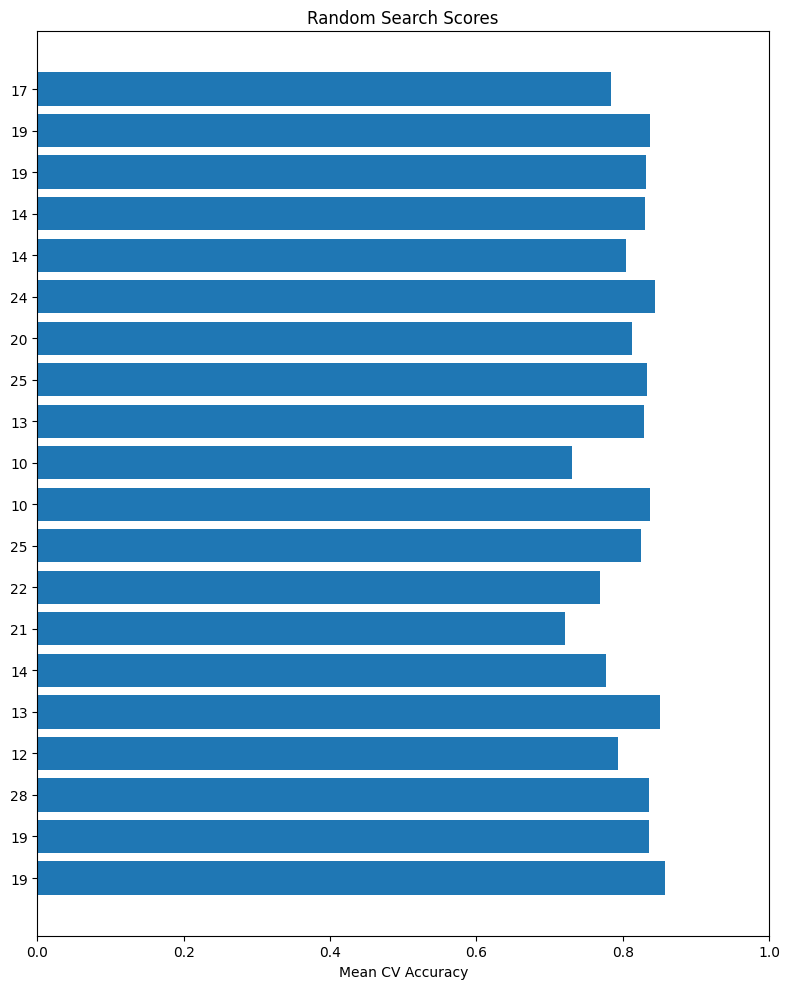

In [94]:
# 하이퍼파라미터 조합별 성능 시각화

# 각 하이퍼파라미터 조합별 교차 검증 스코어 가져오기
results = rs.cv_results_
mean_scores = results['mean_test_score']
params = results['params']

# 시각화를 위한 데이터 준비
max_iter_values = [params[i]['max_iter'] for i in range(len(params))]

# 가로 방향으로 막대 그래프로 교차 검증 스코어 시각화
fig, ax = plt.subplots(figsize=(8, 10))
bars = ax.barh(range(len(mean_scores)), mean_scores, tick_label=[f"{compo}" for compo in max_iter_values])
ax.set_xlabel('Mean CV Accuracy')
ax.set_title('Random Search Scores')
plt.xlim((0, 1))
plt.tight_layout()
plt.show()

In [95]:
# best score, best model, train score, test score

sc = rs.best_estimator_
print ("best score : ", rs.best_score_)
print ("best estimator (model) : ", sc)

sc_score = [sc.score(X_train_scaled, y_train), sc.score(X_test_scaled, y_test)]
print (f"train score, test score : {sc_score}")

best score :  0.8583333333333334
best estimator (model) :  SGDClassifier(loss='log_loss', max_iter=19)
train score, test score : [0.8638888888888889, 0.8611111111111112]


현재 본 dataset의 feature은 7개이므로, 아래와 같은 linear combination formula를 작성할 수 있다.

$z = w_1 \times f_1 + w_2 \times f_2 +  w_3 \times f_3 +  w_4 \times f_4 +  w_5 \times f_5 +  w_6 \times f_6 +  w_7 \times f_7 + bias$

**결과적으로 7개의 model paramter가 loss function의 global minima에 도달할 때까지 learning rate에 의해 조절되어 가면서, 최적의 weight와 bias를 찾게 되는 것**이다. 이를 조금 더 자세히 구현하고 layer 각각을 디자인하기 위해 Dense를 struction한다. 

-------

### 2. ANN (fully connected)
- hidden layer를 구성하지 않고, 입력층과 출력층만 존재하는 인공신경망을 struction할 것이다.
- 우선, 기존 train set에서 validation set을 하나 더 구성하여 추후 evaluation에 사용할 예정이다.
- 또한 one-hot encoding하여 target값을 0과 1로 구성하고 loss function은 categorical_crossentropy를 사용한다.
    - one-hot encoding하는 방식 중 scikit-learn 내장 메소드인 OneHotEncoder를 사용한다.

#### 2-1) validation set 구성 및 one-hot encoding

In [96]:
# train set에서 validation set을 하나 더 구성

X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_train_scaled, y_train,
                                                               test_size=0.2, 
                                                               stratify=y_train)

print (X_train_scaled.shape, X_val_scaled.shape)

(576, 7) (144, 7)


In [97]:
# one-hot encoding

from sklearn.preprocessing import OneHotEncoder

y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)
y_val = y_val.values.reshape(-1, 1)

encoder = OneHotEncoder(sparse=False)
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
y_val = encoder.transform(y_val)

# kecimen, Besni 이렇게 두 target이니, 제대로 one-hot encoding된 것을 확인 가능

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#### 2-2) modelling, compile, fit

records shape :  (8,)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 7)                 0         
                                                                 
 dense_22 (Dense)            (None, 2)                 16        
                                                                 
Total params: 16 (64.00 Byte)
Trainable params: 16 (64.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


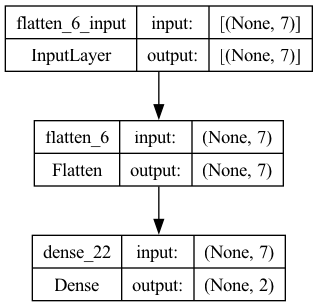

In [98]:
# modelling

print ("records shape : ", df.iloc[0].shape)

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(7, )), 
    keras.layers.Dense(2, activation='sigmoid')
])

model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [99]:
# compile

model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

In [100]:
# fit

history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=20, 
                   validation_data=(X_val_scaled, y_val))

print (history.history)

Epoch 1/50
29/29 [==============================] - 0s 5ms/step - loss: 0.6461 - accuracy: 0.7066 - val_loss: 0.6909 - val_accuracy: 0.6597
Epoch 2/50
29/29 [==============================] - 0s 2ms/step - loss: 0.6092 - accuracy: 0.7552 - val_loss: 0.6594 - val_accuracy: 0.7153
Epoch 3/50
29/29 [==============================] - 0s 2ms/step - loss: 0.5772 - accuracy: 0.8021 - val_loss: 0.6323 - val_accuracy: 0.7569
Epoch 4/50
29/29 [==============================] - 0s 2ms/step - loss: 0.5493 - accuracy: 0.8125 - val_loss: 0.6089 - val_accuracy: 0.7778
Epoch 5/50
29/29 [==============================] - 0s 2ms/step - loss: 0.5249 - accuracy: 0.8229 - val_loss: 0.5888 - val_accuracy: 0.7847
Epoch 6/50
29/29 [==============================] - 0s 2ms/step - loss: 0.5039 - accuracy: 0.8351 - val_loss: 0.5715 - val_accuracy: 0.7847
Epoch 7/50
29/29 [==============================] - 0s 2ms/step - loss: 0.4855 - accuracy: 0.8420 - val_loss: 0.5570 - val_accuracy: 0.7986
Epoch 8/50
29/29 [==

#### 2-3) loss 시각화 및 evaluate

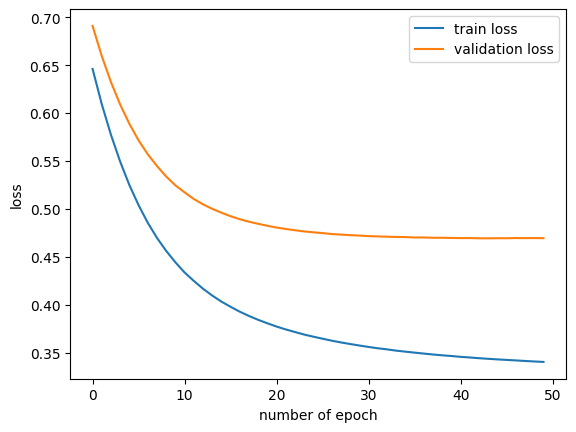

In [101]:
# loss 시각화

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 

위 그래프를 통해 알 수 있는 사실은 아래와 같다.

- **loss 감소 패턴의 동일성**
  - train loss과 validation loss 모두 에포크가 진행됨에 따라 감소하고 있음
  - loss가 줄어든다 -> accuracy가 상승한다.

- **overfitting 여부**
  - 두 손실 곡선이 비슷한 형태로 감소하고 있고, 검증 손실이 훈련 손실보다 크게 차이나지 않기 때문에, overfitting이 심하게 난다고 볼 수 없음
  - 만약 에포크가 더 진행되면 overfitting 발생할 가능성도 있음

- **모델 복잡도**
  - **ANN 모델의 파라미터가 16개밖에 되지 않기 때문에 매우 간단**한 모델
  - 간단한 모델이기 때문에, 학습이 잘 이루어지고 validation data set에 대한 일반화 성능도 준수한 것


In [102]:
# evaluate

model.evaluate(X_val_scaled, y_val)

5/5 [==============================] - 0s 2ms/step - loss: 0.4695 - accuracy: 0.8542


[0.4694508910179138, 0.8541666865348816]

-------

### 3. DNN 
- hidden layer을 충분히 구성하여 신경망을 struction할 것임
    - parameter는 최소한 15000개 이상으로 증폭, 각 node의 activation은 relu 사용
    - epoch는 30으로 고정
- 아래와 같이 experiment할 예정이다.
    - **(1) hidden layer을 추가하여 DNN 구성**
        - (1) 기본 경사 하강법
            - (1-1-1) optimizer : SGD
            - (1-1-2) optimizer : momentum optimization
            - (1-1-3) optimizer : nesterov momentum optimization
            - (1-1-4) 시각화 및 비교
        - (2) 적응적 학습율
            - (1-2-1) optimizer : RMSprop (기본값)
            - (1-2-2) optimizer : Adagrad
            - (1-2-3) optimizer : Adam
            - (1-2-4) 시각화 및 비교
    - **(2) validation loss 감소를 위한 시도**
        - (1) dropout
        - (2) callback : early stopping

#### 3-1) hidden layer를 추가하여 DNN 구성

records shape :  (8,)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 7)                 0         
                                                                 
 dense_23 (Dense)            (None, 256)               2048      
                                                                 
 dense_24 (Dense)            (None, 64)                16448     
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
                                                                 
 dense_26 (Dense)            (None, 16)                528       
                                                                 
 dense_27 (Dense)            (None, 2)                 34        
                                                                 
Total params: 21138 (82.57 KB)
T

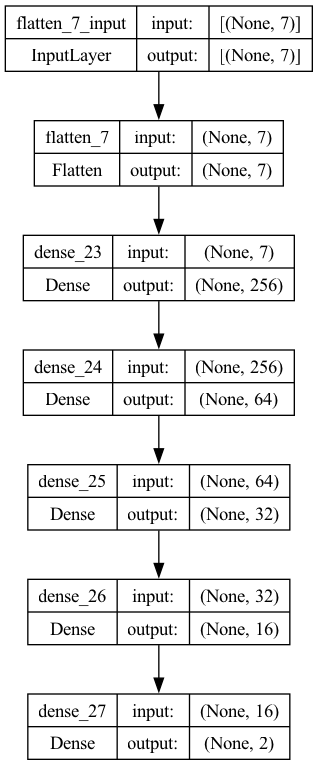

In [103]:
# modelling DNN

print ("records shape : ", df.iloc[0].shape)

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(7, )), 
    keras.layers.Dense(256, activation='relu'), 
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(2, activation='sigmoid')
])

model.summary()
keras.utils.plot_model(model, show_shapes=True)

##### 3-1-1) 기본 경사 하강법
##### (1-1-1) optimizer : SGD

In [104]:
# compile, fit

sgd = keras.optimizers.SGD()
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics='accuracy')
history = model.fit(X_train_scaled, y_train, epochs=30, 
                    validation_data=(X_val_scaled, y_val), batch_size=18)

print (history)

Epoch 1/30
32/32 [==============================] - 1s 5ms/step - loss: 0.6872 - accuracy: 0.5017 - val_loss: 0.6800 - val_accuracy: 0.4931
Epoch 2/30
32/32 [==============================] - 0s 2ms/step - loss: 0.6757 - accuracy: 0.5451 - val_loss: 0.6702 - val_accuracy: 0.5556
Epoch 3/30
32/32 [==============================] - 0s 2ms/step - loss: 0.6646 - accuracy: 0.6580 - val_loss: 0.6594 - val_accuracy: 0.7222
Epoch 4/30
32/32 [==============================] - 0s 2ms/step - loss: 0.6516 - accuracy: 0.7674 - val_loss: 0.6464 - val_accuracy: 0.7917
Epoch 5/30
32/32 [==============================] - 0s 2ms/step - loss: 0.6366 - accuracy: 0.8160 - val_loss: 0.6314 - val_accuracy: 0.8403
Epoch 6/30
32/32 [==============================] - 0s 2ms/step - loss: 0.6191 - accuracy: 0.8333 - val_loss: 0.6142 - val_accuracy: 0.8611
Epoch 7/30
32/32 [==============================] - 0s 2ms/step - loss: 0.5991 - accuracy: 0.8472 - val_loss: 0.5951 - val_accuracy: 0.8611
Epoch 8/30
32/32 [==

In [105]:
# evaluate

sgd_score = model.evaluate(X_val_scaled, y_val)
print (sgd_score)##### (1-1-2) optimizer : momentum optimization

5/5 [==============================] - 0s 2ms/step - loss: 0.4082 - accuracy: 0.8750
[0.40820860862731934, 0.875]


##### (1-1-2) optimizer : momentum optimization

In [106]:
# compile, fit

sgd = keras.optimizers.SGD(momentum=0.9)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics='accuracy')
history = model.fit(X_train_scaled, y_train, epochs=30, 
                    validation_data=(X_val_scaled, y_val), batch_size=18)

print (history)

Epoch 1/30
32/32 [==============================] - 1s 5ms/step - loss: 0.3278 - accuracy: 0.8715 - val_loss: 0.4164 - val_accuracy: 0.8750
Epoch 2/30
32/32 [==============================] - 0s 2ms/step - loss: 0.3231 - accuracy: 0.8750 - val_loss: 0.4241 - val_accuracy: 0.8681
Epoch 3/30
32/32 [==============================] - 0s 2ms/step - loss: 0.3321 - accuracy: 0.8681 - val_loss: 0.4139 - val_accuracy: 0.8681
Epoch 4/30
32/32 [==============================] - 0s 2ms/step - loss: 0.3210 - accuracy: 0.8663 - val_loss: 0.4174 - val_accuracy: 0.8750
Epoch 5/30
32/32 [==============================] - 0s 2ms/step - loss: 0.3163 - accuracy: 0.8750 - val_loss: 0.4134 - val_accuracy: 0.8611
Epoch 6/30
32/32 [==============================] - 0s 2ms/step - loss: 0.3155 - accuracy: 0.8750 - val_loss: 0.4096 - val_accuracy: 0.8750
Epoch 7/30
32/32 [==============================] - 0s 2ms/step - loss: 0.3145 - accuracy: 0.8750 - val_loss: 0.4104 - val_accuracy: 0.8750
Epoch 8/30
32/32 [==

In [107]:
# evaluate

momentum_score = model.evaluate(X_val_scaled, y_val)
print (momentum_score)

5/5 [==============================] - 0s 2ms/step - loss: 0.3838 - accuracy: 0.8750
[0.3837629556655884, 0.875]


##### (1-1-3) optimizer : nesterov momentum optimization

In [108]:
# compile, fit

sgd = keras.optimizers.SGD(momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics='accuracy')
history = model.fit(X_train_scaled, y_train, epochs=30, 
                    validation_data=(X_val_scaled, y_val), batch_size=18)

print (history)

Epoch 1/30
32/32 [==============================] - 1s 5ms/step - loss: 0.2862 - accuracy: 0.8837 - val_loss: 0.3804 - val_accuracy: 0.8611
Epoch 2/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2845 - accuracy: 0.8872 - val_loss: 0.3951 - val_accuracy: 0.8472
Epoch 3/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2848 - accuracy: 0.8767 - val_loss: 0.3809 - val_accuracy: 0.8542
Epoch 4/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2829 - accuracy: 0.8837 - val_loss: 0.3780 - val_accuracy: 0.8542
Epoch 5/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2800 - accuracy: 0.8837 - val_loss: 0.3745 - val_accuracy: 0.8542
Epoch 6/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2790 - accuracy: 0.8906 - val_loss: 0.3811 - val_accuracy: 0.8403
Epoch 7/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2802 - accuracy: 0.8872 - val_loss: 0.3729 - val_accuracy: 0.8542
Epoch 8/30
32/32 [==

In [109]:
# evaluate

nesterov_score = model.evaluate(X_val_scaled, y_val)
print (nesterov_score)

5/5 [==============================] - 0s 2ms/step - loss: 0.3860 - accuracy: 0.8611
[0.38597339391708374, 0.8611111044883728]


##### (1-1-4) 시각화 및 비교

[0.40820860862731934, 0.3837629556655884, 0.38597339391708374, 0.875, 0.875, 0.8611111044883728]


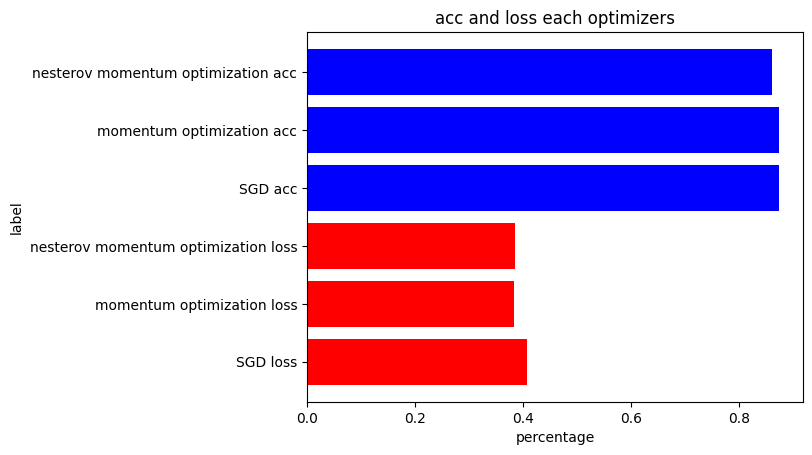

In [110]:
labels = [
    'SGD loss',
    'momentum optimization loss',
    'nesterov momentum optimization loss',
    'SGD acc',
    'momentum optimization acc',
    'nesterov momentum optimization acc',
]

scores = [compo[0] for compo in [sgd_score, momentum_score, nesterov_score]] + [compo[1] for compo in [sgd_score, momentum_score, nesterov_score]]
print (scores)

plt.barh(labels, scores, color=['red' for i in range(3)] + ['blue' for i in range (3)])

plt.xlabel('percentage')
plt.ylabel('label')
plt.title('acc and loss each optimizers')

plt.show()

##### 3-1-2) 적응적 학습율
- 전에 보았던 learning rate는 전부 기본값 0.01로 고정된 채 SGD를 내부적으로 진행한 것
- 모델이 global minima에 가까이 갈 수록 learning rate를 낮추는 optimizer를 사용하면 전보다 더 나은 성능을 보일 수 있을 것이라고 생각한다
<br>

##### (1-2-1) optimizer : RMSprop

In [111]:
# compile, fit

rmsprop = keras.optimizers.RMSprop()
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics='accuracy')
history = model.fit(X_train_scaled, y_train, epochs=30, 
                    validation_data=(X_val_scaled, y_val), batch_size=18)

print (history)

Epoch 1/30
32/32 [==============================] - 1s 5ms/step - loss: 0.2847 - accuracy: 0.8941 - val_loss: 0.3992 - val_accuracy: 0.8403
Epoch 2/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2578 - accuracy: 0.9010 - val_loss: 0.4364 - val_accuracy: 0.7986
Epoch 3/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2493 - accuracy: 0.9028 - val_loss: 0.4028 - val_accuracy: 0.8472
Epoch 4/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2653 - accuracy: 0.9028 - val_loss: 0.3680 - val_accuracy: 0.8681
Epoch 5/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2601 - accuracy: 0.8958 - val_loss: 0.3778 - val_accuracy: 0.8611
Epoch 6/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2549 - accuracy: 0.8993 - val_loss: 0.4128 - val_accuracy: 0.8125
Epoch 7/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2539 - accuracy: 0.9045 - val_loss: 0.4166 - val_accuracy: 0.8125
Epoch 8/30
32/32 [==

In [112]:
# evaluate

rmsprop_score = model.evaluate(X_val_scaled, y_val)
print (rmsprop_score)

5/5 [==============================] - 0s 2ms/step - loss: 0.3736 - accuracy: 0.8472
[0.3735705614089966, 0.8472222089767456]


##### (1-2-2) optimizer : Adagrad

In [113]:
# compile, fit

adagrad = keras.optimizers.Adagrad()
model.compile(optimizer=adagrad, loss='binary_crossentropy', metrics='accuracy')
history = model.fit(X_train_scaled, y_train, epochs=30, 
                    validation_data=(X_val_scaled, y_val), batch_size=18)

print (history) 

Epoch 1/30
32/32 [==============================] - 1s 5ms/step - loss: 0.2080 - accuracy: 0.9219 - val_loss: 0.3747 - val_accuracy: 0.8542
Epoch 2/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2053 - accuracy: 0.9219 - val_loss: 0.3771 - val_accuracy: 0.8542
Epoch 3/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2039 - accuracy: 0.9236 - val_loss: 0.3796 - val_accuracy: 0.8542
Epoch 4/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2030 - accuracy: 0.9236 - val_loss: 0.3815 - val_accuracy: 0.8542
Epoch 5/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2025 - accuracy: 0.9219 - val_loss: 0.3832 - val_accuracy: 0.8542
Epoch 6/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2020 - accuracy: 0.9201 - val_loss: 0.3839 - val_accuracy: 0.8542
Epoch 7/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2017 - accuracy: 0.9236 - val_loss: 0.3847 - val_accuracy: 0.8542
Epoch 8/30
32/32 [==

In [114]:
# evaluate

adagrad_score = model.evaluate(X_val_scaled, y_val)
print (adagrad_score)

5/5 [==============================] - 0s 2ms/step - loss: 0.3910 - accuracy: 0.8611
[0.39095360040664673, 0.8611111044883728]


##### (1-2-3) optimizer : Adam

In [115]:
# compile, fit

adam = keras.optimizers.Adam()
model.compile(optimizer=adam, loss='binary_crossentropy', metrics='accuracy')
history = model.fit(X_train_scaled, y_train, epochs=30, 
                    validation_data=(X_val_scaled, y_val), batch_size=18)

print (history) 

Epoch 1/30
32/32 [==============================] - 1s 8ms/step - loss: 0.2401 - accuracy: 0.9097 - val_loss: 0.3847 - val_accuracy: 0.8264
Epoch 2/30
32/32 [==============================] - 0s 3ms/step - loss: 0.2210 - accuracy: 0.9201 - val_loss: 0.3865 - val_accuracy: 0.8542
Epoch 3/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2137 - accuracy: 0.9167 - val_loss: 0.4073 - val_accuracy: 0.8472
Epoch 4/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2177 - accuracy: 0.9167 - val_loss: 0.4405 - val_accuracy: 0.8472
Epoch 5/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2211 - accuracy: 0.9045 - val_loss: 0.4122 - val_accuracy: 0.8264
Epoch 6/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2197 - accuracy: 0.9149 - val_loss: 0.4065 - val_accuracy: 0.8472
Epoch 7/30
32/32 [==============================] - 0s 3ms/step - loss: 0.2178 - accuracy: 0.9201 - val_loss: 0.4092 - val_accuracy: 0.8403
Epoch 8/30
32/32 [==

In [116]:
# evaluate

adam_score = model.evaluate(X_val_scaled, y_val)
print (adam_score )

5/5 [==============================] - 0s 1ms/step - loss: 0.4145 - accuracy: 0.8611
[0.414496511220932, 0.8611111044883728]


##### (2-1-4) 시각화 및 비교

[0.3735705614089966, 0.39095360040664673, 0.414496511220932, 0.8472222089767456, 0.8611111044883728, 0.8611111044883728]


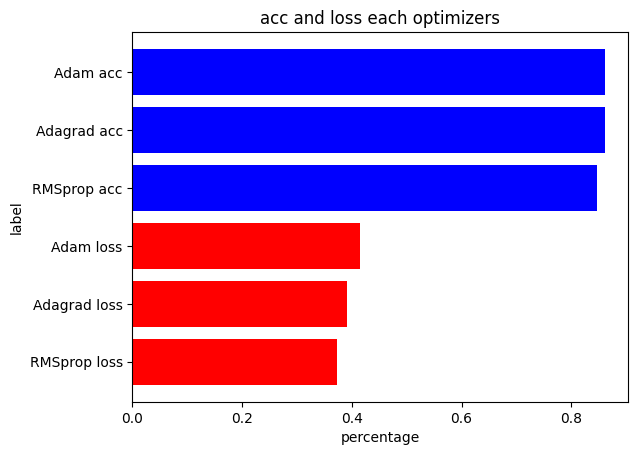

In [117]:
# visualization

labels = [
    'RMSprop loss',
    'Adagrad loss',
    'Adam loss',
    'RMSprop acc',
    'Adagrad acc',
    'Adam acc',
]

scores = [compo[0] for compo in [rmsprop_score, adagrad_score, adam_score]] + [compo[1] for compo in [rmsprop_score, adagrad_score, adam_score]]
print (scores)

plt.barh(labels, scores, color=['red' for i in range(3)] + ['blue' for i in range (3)])

plt.xlabel('percentage')
plt.ylabel('label')
plt.title('acc and loss each optimizers')

plt.show()

위 figure을 보고 다음과 같은 사실을 유추 가능하다.
- **Adagrad의 acc가 가장 높다.**
- Adam의 loss가 가장 높으며, **Adagrad의 loss은 낮은 축에 속한다.**

동일선상에서 비교하였을 때, 현재 dataset에서의 optimizer는 **adagrad가 적합**하다고 볼 수 있다. 따라서 추후 validation loss 감소를 위한 시도 때에서의 model optimizer는 adagrad를 사용할 것이다.

#### 3-2) validation loss 감소를 위한 시도

```sh
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 flatten_6 (Flatten)         (None, 7)                 0         
                                                                 
 dense_10 (Dense)            (None, 256)               2048      
                                                                 
 dense_11 (Dense)            (None, 64)                16448     
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dense_14 (Dense)            (None, 2)                 34        
                                                                 
=================================================================
```
- validation loss 감소를 위하여 아래와 같은 방법을 시도해 볼 것이다.
    - **dropout** 
        - 위 figure를 보았을 때, dense_11에서 param이 가장 많이 밀집된 것을 확인 가능하다. 따라서 여기서 30%의 dropout을 하여 특정 노드의 의존성을 해제하겠다.
    - **early stopping**
        - 5번 연속 검증 점수가 향상되지 않을 시 훈련을 중지할 것이다.

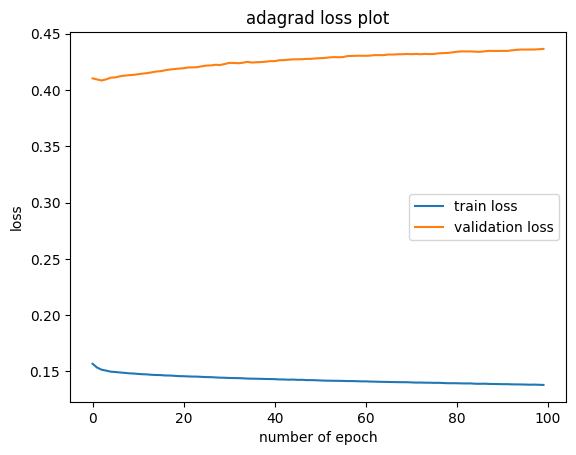

In [118]:
# optimizer인 adagrad를 이용한 compile, fit 및 loss 시각화
# 여기에선 epoch를 100으로 늘려 fit한다.

adagrad = keras.optimizers.Adagrad()
model.compile(optimizer=adagrad, loss='binary_crossentropy', metrics='accuracy')
history = model.fit(X_train_scaled, y_train, epochs=100, 
                    validation_data=(X_val_scaled, y_val), batch_size=18, verbose=0)

plt.title('adagrad loss plot')
plt.plot (history.history['loss'])
plt.plot (history.history['val_loss'])
plt.xlabel ('number of epoch')
plt.ylabel ('loss')
plt.legend(['train loss', 'validation loss'])

plt.show()

**일단 되게 난감한 상황인게, validation loss가 epoch가 늘어남에 따라서 계속적으로 우상향하고 있다.** 이는 즉 학습을 거듭할 수록 overfitting되어가고 있다는 의미인데, 이를 해결하기 위하여 dropout해보자.

##### 3-2-1) dropout

records shape :  (8,)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 7)                 0         
                                                                 
 dense_28 (Dense)            (None, 256)               2048      
                                                                 
 dense_29 (Dense)            (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_30 (Dense)            (None, 32)                2080      
                                                                 
 dense_31 (Dense)            (None, 16)                528       
                                                                 
 dense_32 (Dense)            (No

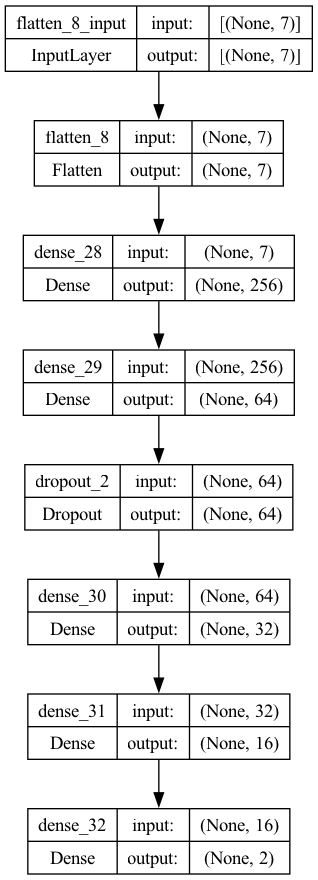

In [119]:
# modelling DNN + dropout

print ("records shape : ", df.iloc[0].shape)

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(7, )), 
    keras.layers.Dense(256, activation='relu'), 
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),  # dropout 층 추가
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(2, activation='sigmoid')
])

model.summary()
keras.utils.plot_model(model, show_shapes=True)

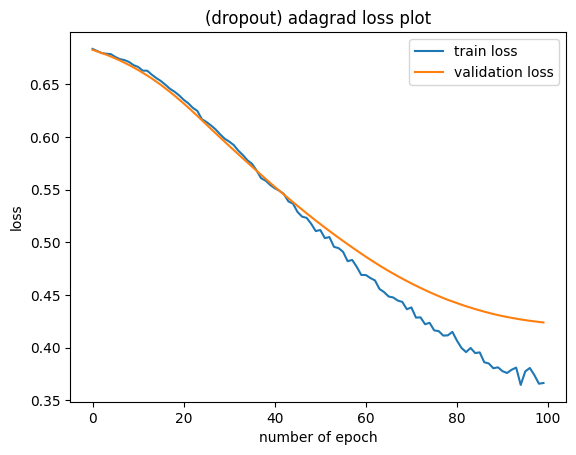

In [120]:
# 재학습 및 재시각화

adagrad = keras.optimizers.Adagrad()
model.compile(optimizer=adagrad, loss='binary_crossentropy', metrics='accuracy')
history = model.fit(X_train_scaled, y_train, epochs=100, 
                    validation_data=(X_val_scaled, y_val), batch_size=18, verbose=0)

plt.title('(dropout) adagrad loss plot')
plt.plot (history.history['loss'])
plt.plot (history.history['val_loss'])
plt.xlabel ('number of epoch')
plt.ylabel ('loss')
plt.legend(['train loss', 'validation loss'])

plt.show()

**overfitting을 막았다.** validation loss는 완벽한 우하향 곡선을 띄고 있는데, 계속적으로 감소하고 있으며 음의 무한대로 발산하고 있다.

In [121]:
# confusion matrix 및 report

from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(X_test_scaled), axis=1)
y_test_labels = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test

print (classification_report(y_test_labels, y_pred))
print (confusion_matrix(y_test_labels, y_pred))

6/6 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.95      0.80      0.87        90
           1       0.83      0.96      0.89        90

    accuracy                           0.88       180
   macro avg       0.89      0.88      0.88       180
weighted avg       0.89      0.88      0.88       180

[[72 18]
 [ 4 86]]


##### 3-2-2) early stopping

In [122]:
# ModelCheckpoint와 EarlyStopping 메소드를 차례대로 사용하여 구현

model.compile(loss='binary_crossentropy', metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('./model/classification_raisin_model_best.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, 
                                                 restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, epochs=100, 
                    validation_data=(X_val_scaled, y_val),
                   callbacks=[checkpoint_cb, early_stopping_cb], verbose=0)

print ("best epochs : ", early_stopping_cb.stopped_epoch)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


best epochs :  15


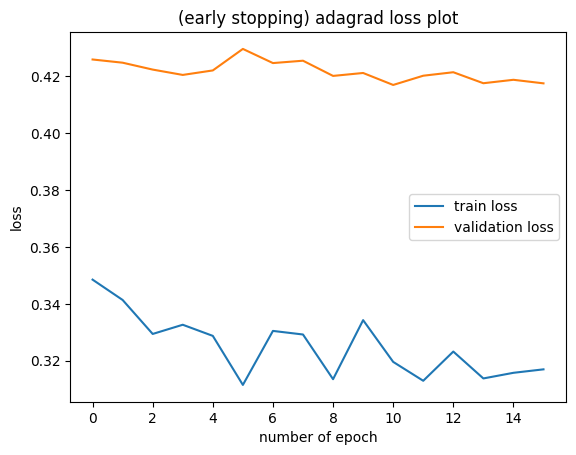

In [123]:
# 시각화

plt.title('(early stopping) adagrad loss plot')
plt.plot (history.history['loss'])
plt.plot (history.history['val_loss'])
plt.xlabel ('number of epoch')
plt.ylabel ('loss')
plt.legend(['train loss', 'validation loss'])

plt.show()

-------

### 4. CNN 
- convolution을 이용하여 유용한 feature을 드러내게 한 후, 그에 따른 유의미한 학습을 진행한다.
- 아래와 같이 진행한다.
    - **(1) reshape and data preparing, label encoding**
    - **(2) modelling**
    - **(3) compile, fit**
    - **(4) evaluation**

#### 4-1) reshape and data preparing, label encoding
- 현재 raisin dataset은 7개의 특성, 1개의 label(target)을 지닌다. CNN으로 하기에 적합하다고 보기 어렵다.
    - 따라서 X_image라고 하는 변수를 만들어, (1, 7, 1) 크기로 redesign한 후에 CNN을 진행한다.
    - train set, validation set, test set을 준비한다.
    - binary classification이기 때문에 to_categorical을 이용하여 binary labelling을 수행한다.
    - label encoding을 통하여 y의 값을 encoding한다.

In [137]:
# input, target을 scaling 및 reshape

ss = StandardScaler()
raisin_input = ss.fit_transform(raisin_input)
X_images = raisin_input.reshape(-1, 7, 1, 1)  # (samples, height, width, channels)

In [138]:
# dataset 분리

X_train, X_test, y_train, y_test = train_test_split(X_images, raisin_target, 
                                                    test_size=0.2, stratify=raisin_target)

In [139]:
# validation set 분리, y_val에 대한 categorical transition 수행

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.2)

In [140]:
# 라벨 인코더를 사용하여 문자열 라벨을 숫자로 변환

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_en = le.fit_transform(y_train)
y_val_en = le.transform(y_val)
y_test_en = le.transform(y_test)

In [141]:
# 이진 라벨로 구성하기 위한 categorical transition 수행

from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train_en, num_classes=2)
y_test = to_categorical(y_test_en, num_classes=2)
y_val = to_categorical(y_val_en, num_classes=2)

#### 4-2) modelling
- 아래와 같이 modelling한다.
    - **convolution layers (feature extractor)**
        - (1) Conv2D로 convolution한 feature map을 생성
            - filter : 32개
            - kernel_size : (3, 1)
            - activation : relu
            - padding : same
                - 입력과 feature map (출력)의 크기를 동일히 하기 위함
        - (2) MaxPooling2D로 각 pooling area마다 중요한 instance get 
            - pooling area size : (2, 1)
        - (3) 다시 Conv2D로 convolution
            - filter : 64개
            - 나머지는 (1)과 동일
        - (4) MaxPooling2D ((2)와 동일)
        - **보류 : Negative dimension size caused by subtracting 2 from 1 오류로 인한 보류**
            - (5) 다시 Conv2D로 convolution
                - filter : 128개
                - 나머지는 (1)과 동일
            - (6) MaxPooling2D ((2)와 동일)
    - **dense layers (classification)**
        - Flatten
        - (1) dense
            - 128개의 뉴런, activation : relu
        - (2) dropout
            - 40% dropout
        - (3) dense
            - 64개의 뉴런, activation : relu
        - (4) dropout
            - 40% dropout
        - (5) dense
            - 32개의 뉴런, activation : relu
        - (6) dense (output layer)
            - 2개 (이진 분류), activation : sigmoid

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 7, 1, 32)          128       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 1, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 1, 64)          6208      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 1, 1, 64)          0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 128)             

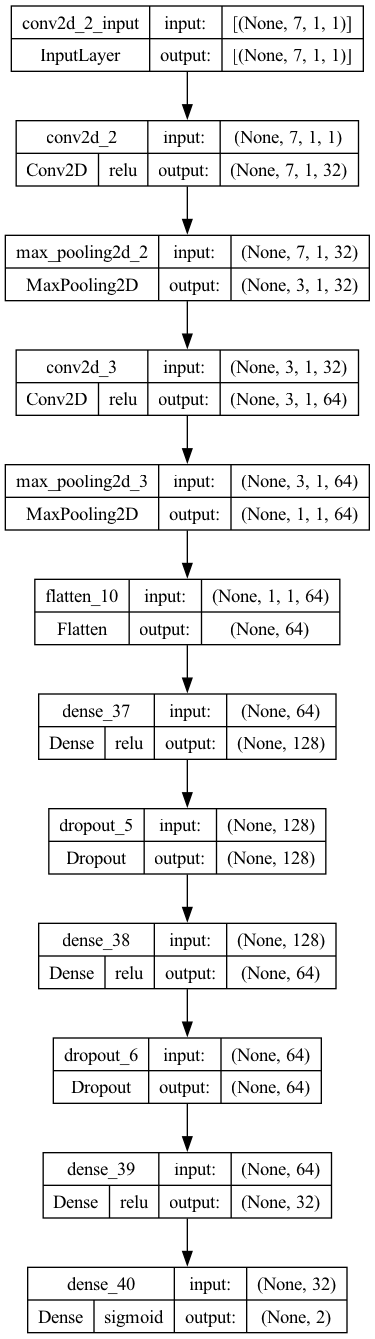

In [142]:
# modelling

model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 1), activation='relu', padding='same', input_shape=(7, 1, 1)),
    keras.layers.MaxPooling2D((2, 1)),
    keras.layers.Conv2D(64, (3, 1), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 1)),
#     keras.layers.Conv2D(128, (3, 1), activation='relu', padding='same'),
#     keras.layers.MaxPooling2D((2, 1)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(2, activation='sigmoid')  # 이진 분류
])

model.summary()
keras.utils.plot_model(model, show_shapes=True,
                      show_layer_names=True, show_layer_activations=True)

#### 4-3) compile, fit
- compile은 다음과 같이 진행한다.
    - optimizer는 적응형 학습율 optimizer인 adagrad을 사용한다.
- overfitting을 방지하고자 early stopping callback을 추가할 것이다.
    - patience를 3으로 한다.
    - epochs는 200으로 한정한다.

In [143]:
# compile and fit

model.compile (optimizer='adagrad', loss='binary_crossentropy',
              metrics='accuracy')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                 restore_best_weights=True)

history = model.fit (X_train, y_train, epochs=200,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping_cb], verbose=2)

Epoch 1/200
18/18 - 1s - loss: 0.6716 - accuracy: 0.5903 - val_loss: 0.6698 - val_accuracy: 0.7361 - 587ms/epoch - 33ms/step
Epoch 2/200
18/18 - 0s - loss: 0.6697 - accuracy: 0.5799 - val_loss: 0.6679 - val_accuracy: 0.7500 - 51ms/epoch - 3ms/step
Epoch 3/200
18/18 - 0s - loss: 0.6639 - accuracy: 0.6163 - val_loss: 0.6659 - val_accuracy: 0.7500 - 50ms/epoch - 3ms/step
Epoch 4/200
18/18 - 0s - loss: 0.6664 - accuracy: 0.6302 - val_loss: 0.6639 - val_accuracy: 0.7708 - 54ms/epoch - 3ms/step
Epoch 5/200
18/18 - 0s - loss: 0.6649 - accuracy: 0.5990 - val_loss: 0.6619 - val_accuracy: 0.7847 - 56ms/epoch - 3ms/step
Epoch 6/200
18/18 - 0s - loss: 0.6624 - accuracy: 0.6146 - val_loss: 0.6599 - val_accuracy: 0.7917 - 51ms/epoch - 3ms/step
Epoch 7/200
18/18 - 0s - loss: 0.6613 - accuracy: 0.6354 - val_loss: 0.6577 - val_accuracy: 0.7917 - 53ms/epoch - 3ms/step
Epoch 8/200
18/18 - 0s - loss: 0.6607 - accuracy: 0.5938 - val_loss: 0.6556 - val_accuracy: 0.7917 - 52ms/epoch - 3ms/step
Epoch 9/200
18

Epoch 68/200
18/18 - 0s - loss: 0.5055 - accuracy: 0.8073 - val_loss: 0.5273 - val_accuracy: 0.8611 - 50ms/epoch - 3ms/step
Epoch 69/200
18/18 - 0s - loss: 0.5009 - accuracy: 0.8108 - val_loss: 0.5257 - val_accuracy: 0.8611 - 49ms/epoch - 3ms/step
Epoch 70/200
18/18 - 0s - loss: 0.4999 - accuracy: 0.8229 - val_loss: 0.5242 - val_accuracy: 0.8611 - 52ms/epoch - 3ms/step
Epoch 71/200
18/18 - 0s - loss: 0.4963 - accuracy: 0.8142 - val_loss: 0.5228 - val_accuracy: 0.8542 - 52ms/epoch - 3ms/step
Epoch 72/200
18/18 - 0s - loss: 0.4995 - accuracy: 0.8212 - val_loss: 0.5213 - val_accuracy: 0.8542 - 51ms/epoch - 3ms/step
Epoch 73/200
18/18 - 0s - loss: 0.4864 - accuracy: 0.8212 - val_loss: 0.5199 - val_accuracy: 0.8542 - 48ms/epoch - 3ms/step
Epoch 74/200
18/18 - 0s - loss: 0.4897 - accuracy: 0.8264 - val_loss: 0.5184 - val_accuracy: 0.8542 - 49ms/epoch - 3ms/step
Epoch 75/200
18/18 - 0s - loss: 0.4872 - accuracy: 0.8229 - val_loss: 0.5170 - val_accuracy: 0.8542 - 51ms/epoch - 3ms/step
Epoch 76

Epoch 134/200
18/18 - 0s - loss: 0.4004 - accuracy: 0.8472 - val_loss: 0.4612 - val_accuracy: 0.8542 - 48ms/epoch - 3ms/step
Epoch 135/200
18/18 - 0s - loss: 0.3945 - accuracy: 0.8351 - val_loss: 0.4609 - val_accuracy: 0.8542 - 48ms/epoch - 3ms/step
Epoch 136/200
18/18 - 0s - loss: 0.3910 - accuracy: 0.8438 - val_loss: 0.4604 - val_accuracy: 0.8542 - 51ms/epoch - 3ms/step
Epoch 137/200
18/18 - 0s - loss: 0.3965 - accuracy: 0.8455 - val_loss: 0.4600 - val_accuracy: 0.8542 - 50ms/epoch - 3ms/step
Epoch 138/200
18/18 - 0s - loss: 0.3920 - accuracy: 0.8403 - val_loss: 0.4595 - val_accuracy: 0.8542 - 51ms/epoch - 3ms/step
Epoch 139/200
18/18 - 0s - loss: 0.3979 - accuracy: 0.8524 - val_loss: 0.4591 - val_accuracy: 0.8542 - 51ms/epoch - 3ms/step
Epoch 140/200
18/18 - 0s - loss: 0.3762 - accuracy: 0.8507 - val_loss: 0.4588 - val_accuracy: 0.8542 - 49ms/epoch - 3ms/step
Epoch 141/200
18/18 - 0s - loss: 0.3922 - accuracy: 0.8472 - val_loss: 0.4585 - val_accuracy: 0.8542 - 48ms/epoch - 3ms/step


#### 4-4) evaluation
- validation loss와 train loss를 시각화
- validation evalutaion, test evaluation
- report 및 confusion matrix 시각화

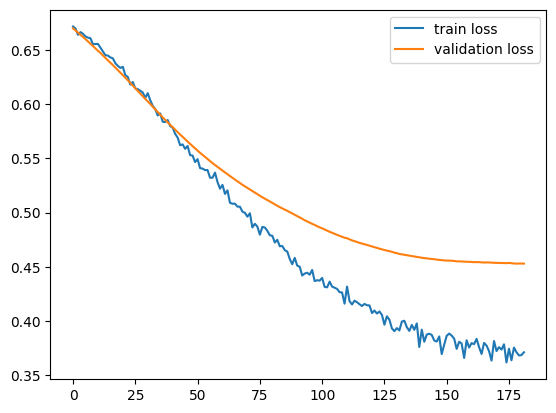

In [144]:
# validation loss와 train loss의 시각화

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train loss', 'validation loss'])
plt.show()

In [145]:
# validation evalutaion과 test evaluation

print(X_val.shape, X_test.shape)

score_val = model.evaluate(X_val, y_val)
score_test = model.evaluate(X_test, y_test)

print (f"validation evaluation : {score_val}")
print (f"test evaluation : {score_test}")

(144, 7, 1, 1) (180, 7, 1, 1)
6/6 [==============================] - 0s 2ms/step - loss: 0.3490 - accuracy: 0.8722
validation evaluation : [0.4530249834060669, 0.8402777910232544]
test evaluation : [0.3490208089351654, 0.8722222447395325]


In [150]:
# confusion matrix 및 report
# validation dataset과 test dataset을 따로 report 및 matrix drawing

y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# 두 unit (besni, kecimen) 중 더 값이 큰 것을 선택하여 prediction class 결정하기
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# cm_val = confusion_matrix(y_val, y_val_pred)
# print ("- validation data confusion matrix -\n")
# print (cm_val)

# print ('\n --------------- \n')

# cm_test = confusion_matrix(y_test, y_test_pred)
# print ("- test data confusion matrix -\n")
# print (cm_test)

# print ('\n --------------- \n')

# cr_val = classification_report(y_val, y_val_pred, target_names=['besni', 'kecimen'])
# print ("- validation data report of classification -\n")
# print (cr_val)

# print ('\n --------------- \n')

# cr_test = classification_report(y_test, y_test_pred, target_names=['besni', 'kecimen'])
# print ("- test data report of classification -\n")
# print (cr_test)

############

cm_val = confusion_matrix(y_val_en, y_val_pred_classes)
print ("- validation data confusion matrix -\n")
print (cm_val)

print ('\n --------------- \n')

cm_test = confusion_matrix(y_test_en, y_test_pred_classes)
print ("- test data confusion matrix -\n")
print (cm_test)

print ('\n --------------- \n')

cr_val = classification_report(y_val_en, y_val_pred_classes, target_names=['besni', 'kecimen'])
print ("- validation data report of classification -\n")
print (cr_val)

print ('\n --------------- \n')

cr_test = classification_report(y_test_en, y_test_pred_classes, target_names=['besni', 'kecimen'])
print ("- test data report of classification -\n")
print (cr_test)

print ('\n --------------- \n')

6/6 [==============================] - 0s 1ms/step
- validation data confusion matrix -

[[52 13]
 [10 69]]

 --------------- 

- test data confusion matrix -

[[73 17]
 [ 6 84]]

 --------------- 

- validation data report of classification -

              precision    recall  f1-score   support

       besni       0.84      0.80      0.82        65
     kecimen       0.84      0.87      0.86        79

    accuracy                           0.84       144
   macro avg       0.84      0.84      0.84       144
weighted avg       0.84      0.84      0.84       144


 --------------- 

- test data report of classification -

              precision    recall  f1-score   support

       besni       0.92      0.81      0.86        90
     kecimen       0.83      0.93      0.88        90

    accuracy                           0.87       180
   macro avg       0.88      0.87      0.87       180
weighted avg       0.88      0.87      0.87       180


 --------------- 

